In [1]:
import os

base_dir = os.getcwd()

# dataset paths
dataset_path = os.path.join(base_dir, 'datasets')
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

# 저장할 model path
save_dir = os.path.join(base_dir, 'saved_models')

classes = ['0_front', '1_back', '1_front', '2_back', '2_front', '5_front', 'ILU']

# train, validation의 각 class별 directory path
train_cls_dirs = [os.path.join(train_dir, c) for c in classes]
val_cls_dirs = [os.path.join(val_dir, c) for c in classes]

In [2]:
import cv2
import numpy as np

# Load dataset
def get_X_y_datas(class_dirs):
    X = []
    y = []
    for i, dir_path in enumerate(class_dirs):
        files = sorted(os.listdir(class_dirs[i]))
        files_paths = [os.path.join(dir_path, f) for f in files]
        
        for file_path in files_paths:
            img_bgr = cv2.imread(file_path, cv2.IMREAD_COLOR)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            input_img = img_rgb.astype(np.float32)/255.
            
            X.append(input_img)
            y.append(int(i))
            
    return np.array(X), np.array(y).astype(np.uint8)

In [3]:
from tensorflow.keras.utils import to_categorical

num_classes = 7

# Load train, validation datas
X_train, y_train = get_X_y_datas(train_cls_dirs)
X_val, y_val = get_X_y_datas(val_cls_dirs)

# Shuffle
idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[idx], y_train[idx]

idx = np.random.permutation(len(X_val))
X_val, y_val = X_val[idx], y_val[idx]

# one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(18654, 250, 200, 3) (18654, 7)
(9222, 250, 200, 3) (9222, 7)


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop

# 학습에 사용할 callback
callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
    ),
    ModelCheckpoint(
        filepath=os.path.join(save_dir, 'hand_sign_fine_tune_vgg16.h5'),
        monitor='val_loss',
        save_best_only=True,
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    )
]

In [5]:
import tensorflow as tf

# 2-1에서 학습한 모델 불러오기
model = tf.keras.models.load_model("./saved_models/hand_sign_fine_tune_vgg16.h5")

In [6]:
# vgg16 모델 layer 찾아서 가져오기
for layer in model.layers:
    print(layer.name)
vgg16 = model.layers[0]

# 학습되도록 설정
vgg16.trainable = True

# 제일 마지막 conv block(conv layer 4개)만 제외하고 모두 학습되지 않도록 설정
for layer in vgg16.layers[:-4]:
    layer.trainable = False

vgg16
flatten
dense
batch_normalization
re_lu
dropout
dense_1
batch_normalization_1
re_lu_1
dropout_1
dense_2


In [7]:
# fine tuning시에는 이미 학습된 표현을 조금씩 수정하기 위해 learning rate를 작게 설정
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [8]:
n_epochs=100
batch_size=64

history = model.fit(X_train, y_train,
                    epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list)

Train on 18654 samples, validate on 9222 samples
Epoch 1/100
18654/18654 [==============================] - 50s 3ms/sample - loss: 0.1649 - acc: 0.9499 - val_loss: 3.1625 - val_acc: 0.7264
Epoch 2/100
18654/18654 [==============================] - 45s 2ms/sample - loss: 0.0751 - acc: 0.9774 - val_loss: 0.3484 - val_acc: 0.9376
Epoch 3/100
18654/18654 [==============================] - 44s 2ms/sample - loss: 0.0416 - acc: 0.9874 - val_loss: 0.3645 - val_acc: 0.9358
Epoch 4/100
18654/18654 [==============================] - 45s 2ms/sample - loss: 0.0245 - acc: 0.9922 - val_loss: 0.2474 - val_acc: 0.9526
Epoch 5/100
18654/18654 [==============================] - 45s 2ms/sample - loss: 0.0188 - acc: 0.9943 - val_loss: 0.2244 - val_acc: 0.9465
Epoch 6/100
18654/18654 [==============================] - 45s 2ms/sample - loss: 0.0141 - acc: 0.9963 - val_loss: 0.1219 - val_acc: 0.9694
Epoch 7/100
18654/18654 [==============================] - 44s 2ms/sample - loss: 0.0103 - acc: 0.9971 - val_lo

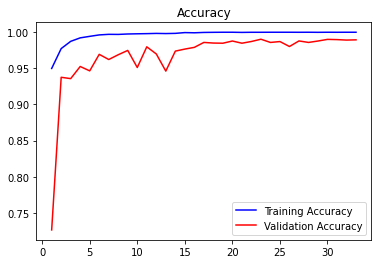

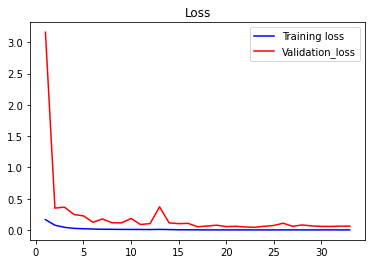

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy curve
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()

# Plot loss curve
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation_loss')
plt.title('Loss')
plt.legend()

plt.show()

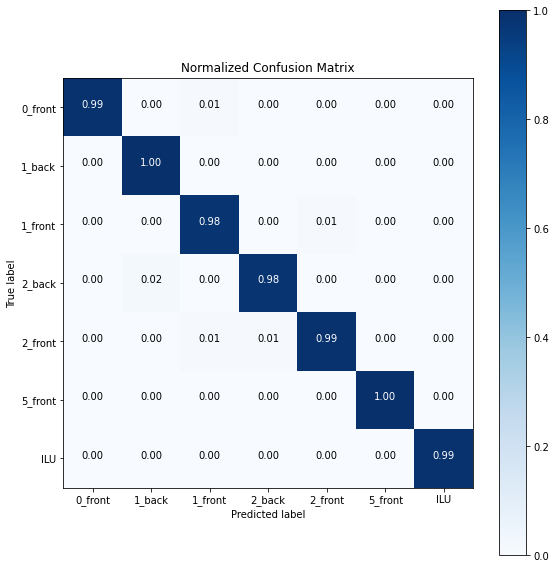

In [10]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

y_preds = model.predict(X_val)
y_preds = np.argmax(y_preds, axis=1)
conf_mx = confusion_matrix(np.argmax(y_val, axis=1), y_preds)

confusion_matrix_plot(conf_mx, classes=classes)